In [72]:
import numpy
import pandas
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.svm

from matplotlib import pyplot
%matplotlib inline

In [43]:
train_data = pandas.read_csv("train.csv.gz").values
X, y = train_data[:, 1:] / 255.0, train_data[:, 0]
print("X:", X.shape)
print("y:", y.shape)

X: (42000, 784)
y: (42000,)


In [44]:
X_test = pandas.read_csv("test.csv.gz").values
print("Test X:", X_test.shape)

Test X: (28000, 784)


# PCA

In [45]:
pca = sklearn.decomposition.PCA().fit(X)

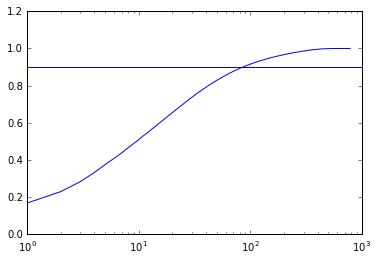

In [46]:
pyplot.plot(numpy.cumsum(pca.explained_variance_ratio_))
pyplot.axhline(y=0.9)
pyplot.xscale("log")
pyplot.show()

In [53]:
X_pca = pca.transform(X)

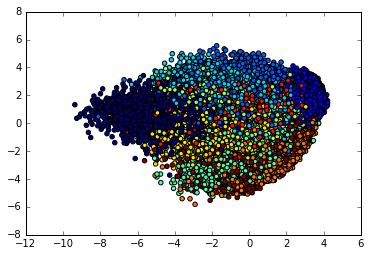

In [54]:
pyplot.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
pyplot.show()

# Random Forest

In [49]:
numpy.random.seed(0)

rfc_model = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    max_features="sqrt",
), {
    "n_estimators": [500],
    "max_depth": [100],
}, verbose=3).fit(X, y)

print("Score:", rfc_model.best_score_)
print("Params:", rfc_model.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.963153 -  59.6s
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.963495 -  52.1s
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.966209 -  45.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished


Score: 0.964285714286
Params: {'n_estimators': 500, 'max_depth': 100}


In [50]:
y_test = numpy.array(list(enumerate(rfc_model.best_estimator_.predict(X_test), start=1)))
print("Y test:", y_test.shape)
numpy.savetxt("answer_rfc.csv", y_test, fmt="%d,\"%d\"", header="\"ImageId\",\"Label\"", comments="")

Y test: (28000, 2)


# Bayes

In [51]:
numpy.random.seed(0)

for model in [
    sklearn.naive_bayes.GaussianNB(),
    sklearn.naive_bayes.BernoulliNB(),
    sklearn.naive_bayes.MultinomialNB(),
]:
    print("%s: %s" % (model, sklearn.cross_validation.cross_val_score(model, X, y).mean()))

GaussianNB(): 0.562237774695
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True): 0.832999717714
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True): 0.823642431638


## PCA + Bayes

In [52]:
numpy.random.seed(0)

for model in [
    sklearn.naive_bayes.GaussianNB(),
    sklearn.naive_bayes.BernoulliNB(),
]:
    print("%s: %s" % (model, sklearn.cross_validation.cross_val_score(model, X_transformed[:, :100], y).mean()))

GaussianNB(): 0.869833232797
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True): 0.738832880561


# SVD

In [69]:
svd = sklearn.decomposition.TruncatedSVD(n_components=100).fit(X)
X_svd = svd.transform(X)

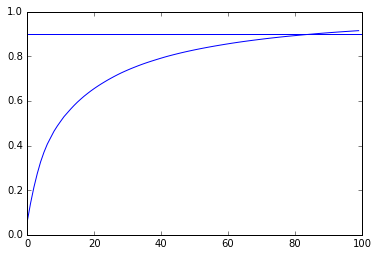

In [70]:
pyplot.plot(numpy.cumsum(svd.explained_variance_ratio_))
pyplot.axhline(y=0.9)
pyplot.show()

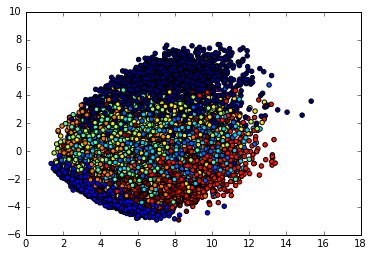

In [71]:
pyplot.scatter(X_svd[:, 0], X_svd[:, 1], c=y)
pyplot.show()

# PCA + kNN

In [88]:
numpy.random.seed(0)

for n_components in range(30, 35):
    X_pca = sklearn.decomposition.PCA(n_components=n_components).fit_transform(numpy.vstack([X, X_test]))
    estimator = sklearn.neighbors.KNeighborsClassifier(weights="distance", n_jobs=-1)
    knn_model = sklearn.grid_search.GridSearchCV(estimator, {"n_neighbors": [2, 3, 4, 5, 6]}).fit(X_pca[:X.shape[0], :], y)

    print("Components:", n_components)
    print("Score:", knn_model.best_score_)
    print("Params:", knn_model.best_params_)

Components: 30
Score: 0.973452380952
Params: {'n_neighbors': 4}
Components: 31
Score: 0.973380952381
Params: {'n_neighbors': 4}
Components: 32
Score: 0.973547619048
Params: {'n_neighbors': 4}
Components: 33
Score: 0.973785714286
Params: {'n_neighbors': 4}
Components: 34
Score: 0.973976190476
Params: {'n_neighbors': 4}


In [94]:
X_pca_knn = sklearn.decomposition.PCA(n_components=34).fit_transform(numpy.vstack([X, X_test]))

In [95]:
pca_knn_model = \
    sklearn.neighbors.KNeighborsClassifier(weights="distance", n_jobs=-1, n_neighbors=4).\
    fit(X_pca_knn[:X.shape[0], :], y)

In [96]:
# For some unknown reason this gives only 0.65471.
y_test = pca_knn_model.predict(X_pca_knn[X.shape[0]:, :])
y_test_answer = numpy.array(list(enumerate(y_test, start=1)))
numpy.savetxt("answer_pca_knn.csv", y_test_answer, fmt="%d,\"%d\"", header="\"ImageId\",\"Label\"", comments="")